### Behaviour by model:

In [1]:
import xarray
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
import matplotlib as mpl
import warnings
import cmasher as cmr
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [2]:
# 0 = Whole UK
# 1 = East Midlands
# 2 = East of England
# 3 = East Scotland
# 4 = London
# 5 = North-East England
# 6 = North Scotland
# 7 = North-West England
# 8 = South-East England
# 9 = South-West England
# 10 = West Midlands
# 11 = West Scotland
# 12 = Yorkshire and Humberside
# 13 = Channel Islands?
# 14 = Isle of Man?
# 15 = Northern Ireland
# 16 = Wales

In [2]:
def get_cordex_addresses():
    models = pd.read_csv('cordex_models.txt', sep='\t')
    root = '/data/met/ukcordex/'
    directories = [root + models['GCM'][i] + '/' +
                   models['RCM'][i] + '/' +
                   models['Ensemble'][i] + '/dmo/'
                   for i in range(models.shape[0])]
    tas_files  = []
    hurs_files = []
    pr_files   = []
    wind_files = []
    err_indexs = []
    print(type(err_indexs))
    for i in range(models.shape[0]):
        try:
            for f_name in os.listdir(directories[i]):
                if f_name.startswith('tas_'):
                    tas_files.append(str(f_name))
                if f_name.startswith('hurs_'):
                    hurs_files.append(str(f_name))
                if f_name.startswith('sfcWind_'):
                    wind_files.append(str(f_name))
                if f_name.startswith('pr_'):
                    pr_files.append(str(f_name))
        except OSError as error:
            print(f'Inelligible directory at: {directories[i]}')
            err_indexs.append(int(i))
    for i in range(len(err_indexs)):
        del directories[err_indexs[i]]
    return directories,tas_files,hurs_files,wind_files,pr_files

In [3]:
region_data  = xarray.open_dataset('/home/theo/data/ukcp18-uk-land-region-rll.nc')
region_mask = region_data.admin_region
region_mask = np.nan_to_num(region_mask)
directories,tas_files,hurs_files,wind_files,pr_files = get_cordex_addresses()
mask = (region_mask == 0).astype(int)
mask = np.logical_not(mask)
print(len(directories))

<class 'list'>
49


In [6]:
# Loading data:

# 1-48 as model 0 has a corrupted hurs output

tas_file_names = [f'/home/theo/outdata/01_data/tas_model_{i+1}_region_0_summer.npy' 
              for i in range(1,49)]
tas_data = np.array([np.load(fname) for fname in tas_file_names])
hurs_file_names = [f'/home/theo/outdata/01_data/hurs_model_{i+1}_region_0_summer.npy' 
              for i in range(1,49)]
hurs_data = np.array([np.load(fname) for fname in hurs_file_names])
wind_file_names = [f'/home/theo/outdata/01_data/wind_model_{i+1}_region_0_summer.npy' 
              for i in range(1,49)]
wind_data = np.array([np.load(fname) for fname in wind_file_names])
pr_file_names = [f'/home/theo/outdata/01_data/pr_model_{i+1}_region_0_summer.npy' 
              for i in range(1,49)]
pr_data = np.array([np.load(fname) for fname in pr_file_names])

In [35]:
mse  = np.average((tas_data - mean_tas)**2,axis=1)
bias = np.average(tas_data - mean_tas,axis=1)
var  = mse - bias**2
print(np.mean(bias**2/var))


mse  = np.average((pr_data - mean_pr)**2,axis=1)
bias = np.average(pr_data - mean_pr,axis=1)
var  = mse - bias**2
print(np.mean(bias**2/var))

mse  = np.average((wind_data - mean_wind)**2,axis=1)
bias = np.average(wind_data - mean_wind,axis=1)
var  = mse - bias**2
print(np.mean(bias**2/var))

mse  = np.average((hurs_data - mean_hurs)**2,axis=1)
bias = np.average(hurs_data - mean_hurs,axis=1)
var  = mse - bias**2
print(np.mean(bias**2/var))


1.4010566700714062
1.2375576982900875
2.4210484692822916
4.766795783184482


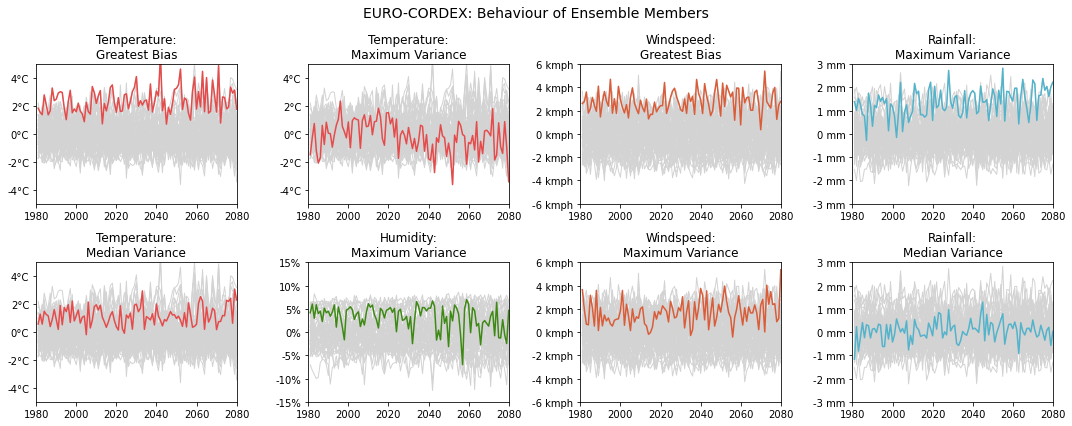

In [21]:
dates = np.array([1981 + i for i in range(100)])
mean_tas = np.mean(tas_data,axis=0)

mse  = np.average((tas_data - mean_tas)**2,axis=1)
bias = np.average(tas_data - mean_tas,axis=1)
var  = mse - bias**2

varhist,edges = np.histogram(var)
varbincenters = 0.5 * (edges[1:] + edges[:-1])
msehist,edges = np.histogram(mse)
msebincenters = 0.5 * (edges[1:] + edges[:-1])
biashist,edges = np.histogram(bias**2)
biasbincenters = 0.5 * (edges[1:] + edges[:-1])

max_bias = np.argmax(bias)
min_bias = np.argmin(bias)
max_var  = np.argmax(var)
med_var  = np.where(np.median(var))
med_mse  = np.where(np.median(mse))


fig = plt.figure(figsize=(15, 6),tight_layout=True)

fig.suptitle('EURO-CORDEX: Behaviour of Ensemble Members',fontsize = 14)

widths = [1.3, 1.3, 1.3, 1.3]
heights = [1, 1]
grid = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths,height_ratios=heights)


ax_1 = fig.add_subplot(grid[0,0])
for k in range(48):
    ax_1.plot(dates,tas_data[k,:]-np.nanmean(tas_data,axis = 0),color='lightgray',linewidth=1)
ax_1.plot(dates,tas_data[max_bias,:]-np.nanmean(tas_data,axis = 0),color='#E54B4B',linewidth=1.5)
ax_1.set_title(f'Temperature:\nGreatest Bias',fontsize=12)
ax_1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
ax_1.set_xlim(1980,2080)
ax_1.set_ylim(-5,5)
ax_1.margins(x=0)

ax_2 = fig.add_subplot(grid[1,0])
for k in range(48):
    ax_2.plot(dates,tas_data[k,:]-np.nanmean(tas_data,axis = 0),color='lightgray',linewidth=1)
ax_2.plot(dates,tas_data[med_var,:][0,0,:]-np.nanmean(tas_data,axis = 0),color='#E54B4B',linewidth=1.5)
ax_2.set_title(f'Temperature:\nMedian Variance',fontsize=12)
ax_2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
ax_2.set_xlim(1980,2080)
ax_2.set_ylim(-5,5)
ax_2.margins(x=0)

ax_3 = fig.add_subplot(grid[0,1])
for k in range(48):
    ax_3.plot(dates,tas_data[k,:]-np.nanmean(tas_data,axis = 0),color='lightgray',linewidth=1)
ax_3.plot(dates,tas_data[max_var,:]-np.nanmean(tas_data,axis = 0),color='#E54B4B',linewidth=1.5)
ax_3.set_title(f'Temperature:\nMaximum Variance',fontsize=12)
ax_3.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
ax_3.set_xlim(1980,2080)
ax_3.set_ylim(-5,5)
ax_3.margins(x=0)

dates = np.array([1981 + i for i in range(100)])
mean_hurs = np.mean(hurs_data,axis=0)
mse  = np.average((hurs_data - mean_hurs)**2,axis=1)
bias = np.average(hurs_data - mean_hurs,axis=1)
var  = mse - bias**2
max_bias = np.argmax(bias)
min_bias = np.argmin(bias)
max_var  = np.argmax(var)
med_var  = np.where(np.median(var))
med_mse  = np.where(np.median(mse))
bound = 15

ax_4 = fig.add_subplot(grid[1,1])
for k in range(48):
    ax_4.plot(dates,hurs_data[k,:]-np.nanmean(hurs_data,axis = 0),color='lightgray',linewidth=1)
ax_4.plot(dates,hurs_data[max_var,:]-np.nanmean(hurs_data,axis = 0),color='#3E8914',linewidth=1.5)
ax_4.set_title(f'Humidity:\nMaximum Variance',fontsize=12)
ax_4.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}%"))
ax_4.set_xlim(1980,2080)
ax_4.set_ylim(-bound,bound)
ax_4.margins(x=0)


mean_wind = np.mean(wind_data,axis=0)
mse  = np.average((wind_data - mean_wind)**2,axis=1)
bias = np.average(wind_data - mean_wind,axis=1)
var  = mse - bias**2
max_bias = np.argmax(bias)
min_bias = np.argmin(bias)
max_var  = np.argmax(var)
med_var  = np.where(np.median(var))
med_mse  = np.where(np.median(mse))
bound = 6


ax_5 = fig.add_subplot(grid[0,2])
for k in range(48):
    ax_5.plot(dates,wind_data[k,:]-np.nanmean(wind_data,axis = 0),color='lightgray',linewidth=1)
ax_5.plot(dates,wind_data[max_bias,:]-np.nanmean(wind_data,axis = 0),color='#D95D39',linewidth=1.5)
ax_5.set_title(f'Windspeed:\nGreatest Bias',fontsize=12)
ax_5.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} kmph"))
ax_5.set_xlim(1980,2080)
ax_5.set_ylim(-bound,bound)
ax_5.margins(x=0)

ax_6 = fig.add_subplot(grid[1,2])
for k in range(48):
    ax_6.plot(dates,wind_data[k,:]-np.nanmean(wind_data,axis = 0),color='lightgray',linewidth=1)
ax_6.plot(dates,wind_data[max_var,:]-np.nanmean(wind_data,axis = 0),color='#D95D39',linewidth=1.5)
ax_6.set_title(f'Windspeed:\nMaximum Variance',fontsize=12)
ax_6.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} kmph"))
ax_6.set_xlim(1980,2080)
ax_6.set_ylim(-bound,bound)
ax_6.margins(x=0)


mean_pr = np.mean(pr_data,axis=0)
mse  = np.average((pr_data - mean_pr)**2,axis=1)
bias = np.average(pr_data - mean_pr,axis=1)
var  = mse - bias**2
max_bias = np.argmax(bias)
min_bias = np.argmin(bias)
max_var  = np.argmax(var)
med_var  = np.where(np.median(var))
med_mse  = np.where(np.median(mse))
bound = 3


ax_7 = fig.add_subplot(grid[0,3])
for k in range(48):
    ax_7.plot(dates,pr_data[k,:]-np.nanmean(pr_data,axis = 0),color='lightgray',linewidth=1)
ax_7.plot(dates,pr_data[max_var,:]-np.nanmean(pr_data,axis = 0),color='#53B3CB',linewidth=1.5)
ax_7.set_title(f'Rainfall:\nMaximum Variance',fontsize=12)
ax_7.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} mm"))
ax_7.set_xlim(1980,2080)
ax_7.set_ylim(-bound,bound)
ax_7.margins(x=0)

ax_8 = fig.add_subplot(grid[1,3])
for k in range(48):
    ax_8.plot(dates,pr_data[k,:]-np.nanmean(pr_data,axis = 0),color='lightgray',linewidth=1)
ax_8.plot(dates,pr_data[med_var[0][0],:]-np.nanmean(pr_data,axis = 0),color='#53B3CB',linewidth=1.5)
ax_8.set_title(f'Rainfall:\nMedian Variance',fontsize=12)
ax_8.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} mm"))
ax_8.set_xlim(1980,2080)
ax_8.set_ylim(-bound,bound)
ax_8.margins(x=0)

plt.tight_layout()
plt.savefig('/home/theo/final_images/1.4.images/_combo_plot')

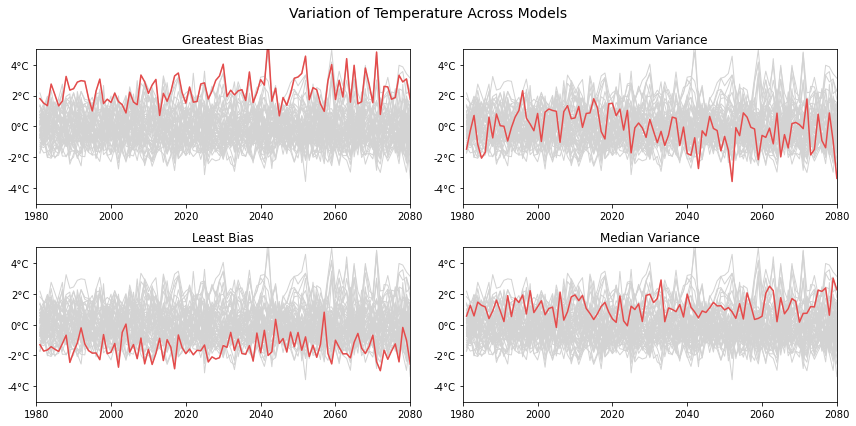

<Figure size 432x288 with 0 Axes>

In [27]:
dates = np.array([1981 + i for i in range(100)])
mean_tas = np.mean(tas_data,axis=0)

mse  = np.average((tas_data - mean_tas)**2,axis=1)
bias = np.average(tas_data - mean_tas,axis=1)
var  = mse - bias**2

varhist,edges = np.histogram(var)
varbincenters = 0.5 * (edges[1:] + edges[:-1])
msehist,edges = np.histogram(mse)
msebincenters = 0.5 * (edges[1:] + edges[:-1])
biashist,edges = np.histogram(bias**2)
biasbincenters = 0.5 * (edges[1:] + edges[:-1])

max_bias = np.argmax(bias)
min_bias = np.argmin(bias)
max_var  = np.argmax(var)
med_var  = np.where(np.median(var))
med_mse  = np.where(np.median(mse))


fig = plt.figure(figsize=(12, 6),tight_layout=True)

fig.suptitle('Variation of Temperature Across Models',fontsize = 14)

widths = [1, 1]
heights = [1, 1]
grid = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths,height_ratios=heights)


ax_1 = fig.add_subplot(grid[0,0])
for k in range(48):
    ax_1.plot(dates,tas_data[k,:]-np.nanmean(tas_data,axis = 0),color='lightgray',linewidth=1)
ax_1.plot(dates,tas_data[max_bias,:]-np.nanmean(tas_data,axis = 0),color='#E54B4B',linewidth=1.5)
ax_1.set_title(f'Greatest Bias',fontsize=12)
ax_1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
ax_1.set_xlim(1980,2080)
ax_1.set_ylim(-5,5)
ax_1.margins(x=0)

ax_2 = fig.add_subplot(grid[1,0])
for k in range(48):
    ax_2.plot(dates,tas_data[k,:]-np.nanmean(tas_data,axis = 0),color='lightgray',linewidth=1)
ax_2.plot(dates,tas_data[max_var,:]-np.nanmean(tas_data,axis = 0),color='#E54B4B',linewidth=1.5)
ax_2.set_title(f'Maximum Variance',fontsize=12)
ax_2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
ax_2.set_xlim(1980,2080)
ax_2.set_ylim(-5,5)
ax_2.margins(x=0)

ax_3 = fig.add_subplot(grid[0,1])
for k in range(48):
    ax_3.plot(dates,tas_data[k,:]-np.nanmean(tas_data,axis = 0),color='lightgray',linewidth=1)
ax_3.plot(dates,tas_data[med_var[0][0],:]-np.nanmean(tas_data,axis = 0),color='#E54B4B',linewidth=1.5)
ax_3.set_title(f'Median Variance',fontsize=12)
ax_3.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
ax_3.set_xlim(1980,2080)
ax_3.set_ylim(-5,5)
ax_3.margins(x=0)





plt.tight_layout()
plt.show()
plt.savefig('/home/theo/final_images/1.4.images/_temperature')

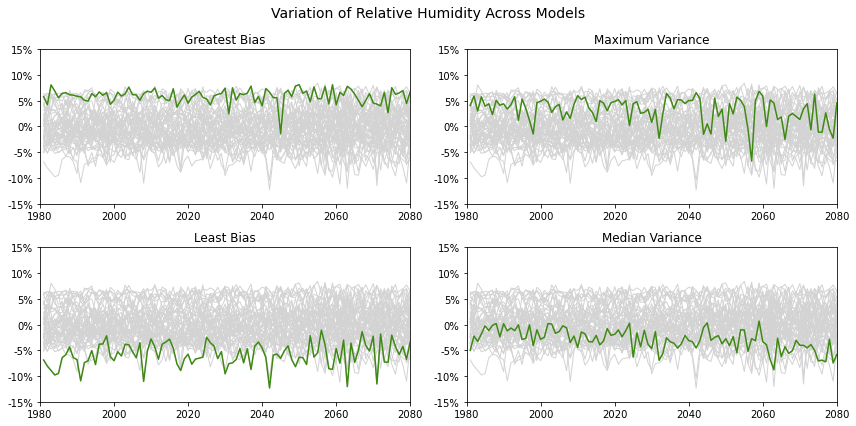

<Figure size 432x288 with 0 Axes>

In [35]:
dates = np.array([1981 + i for i in range(100)])
mean_hurs = np.mean(hurs_data,axis=0)

mse  = np.average((hurs_data - mean_hurs)**2,axis=1)
bias = np.average(hurs_data - mean_hurs,axis=1)
var  = mse - bias**2

varhist,edges = np.histogram(var)
varbincenters = 0.5 * (edges[1:] + edges[:-1])
msehist,edges = np.histogram(mse)
msebincenters = 0.5 * (edges[1:] + edges[:-1])
biashist,edges = np.histogram(bias**2)
biasbincenters = 0.5 * (edges[1:] + edges[:-1])

max_bias = np.argmax(bias)
min_bias = np.argmin(bias)
max_var  = np.argmax(var)
med_var  = np.where(np.median(var))
med_mse  = np.where(np.median(mse))


fig = plt.figure(figsize=(12, 6),tight_layout=True)

fig.suptitle('Variation of Relative Humidity Across Models',fontsize = 14)

widths = [1, 1]
heights = [1, 1]
grid = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths,height_ratios=heights)
bound = 15

ax_2 = fig.add_subplot(grid[0,0])
for k in range(48):
    ax_2.plot(dates,hurs_data[k,:]-np.nanmean(hurs_data,axis = 0),color='lightgray',linewidth=1)
ax_2.plot(dates,hurs_data[max_bias,:]-np.nanmean(hurs_data,axis = 0),color='#3E8914',linewidth=1.5)
ax_2.set_title(f'Greatest Bias',fontsize=12)
ax_2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}%"))
ax_2.set_xlim(1980,2080)
ax_2.set_ylim(-bound,bound)
ax_2.margins(x=0)

ax_3 = fig.add_subplot(grid[1,0])
for k in range(48):
    ax_3.plot(dates,hurs_data[k,:]-np.nanmean(hurs_data,axis = 0),color='lightgray',linewidth=1)
ax_3.plot(dates,hurs_data[min_bias,:]-np.nanmean(hurs_data,axis = 0),color='#3E8914',linewidth=1.5)
ax_3.set_title(f'Least Bias',fontsize=12)
ax_3.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}%"))
ax_3.set_xlim(1980,2080)
ax_3.set_ylim(-bound,bound)
ax_3.margins(x=0)

ax_4 = fig.add_subplot(grid[0,1])
for k in range(48):
    ax_4.plot(dates,hurs_data[k,:]-np.nanmean(hurs_data,axis = 0),color='lightgray',linewidth=1)
ax_4.plot(dates,hurs_data[max_var,:]-np.nanmean(hurs_data,axis = 0),color='#3E8914',linewidth=1.5)
ax_4.set_title(f'Maximum Variance',fontsize=12)
ax_4.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}%"))
ax_4.set_xlim(1980,2080)
ax_4.set_ylim(-bound,bound)
ax_4.margins(x=0)

ax_5 = fig.add_subplot(grid[1,1])
for k in range(48):
    ax_5.plot(dates,hurs_data[k,:]-np.nanmean(hurs_data,axis = 0),color='lightgray',linewidth=1)
ax_5.plot(dates,hurs_data[med_var[0][0],:]-np.nanmean(hurs_data,axis = 0),color='#3E8914',linewidth=1.5)
ax_5.set_title(f'Median Variance',fontsize=12)
ax_5.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}%"))
ax_5.set_xlim(1980,2080)
ax_5.set_ylim(-bound,bound)
ax_5.margins(x=0)

plt.tight_layout()
plt.show()
plt.savefig('/home/theo/final_images/1.4.images/_relative_humidity')

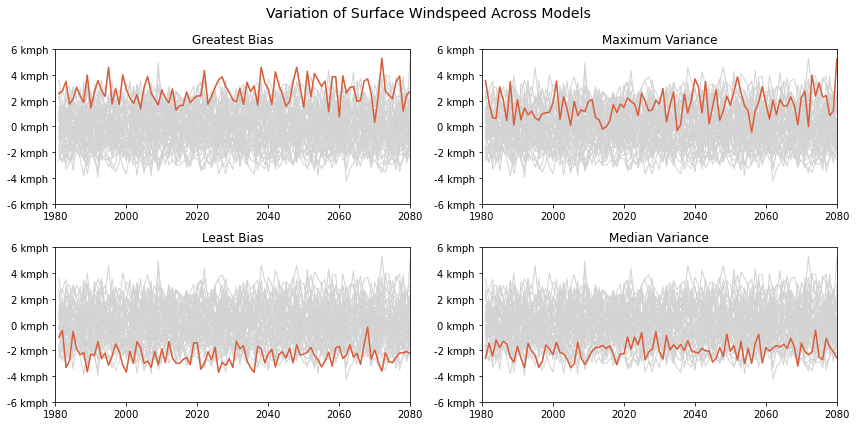

<Figure size 432x288 with 0 Axes>

In [30]:
dates = np.array([1981 + i for i in range(100)])
mean_wind = np.mean(wind_data,axis=0)

mse  = np.average((wind_data - mean_wind)**2,axis=1)
bias = np.average(wind_data - mean_wind,axis=1)
var  = mse - bias**2

varhist,edges = np.histogram(var)
varbincenters = 0.5 * (edges[1:] + edges[:-1])
msehist,edges = np.histogram(mse)
msebincenters = 0.5 * (edges[1:] + edges[:-1])
biashist,edges = np.histogram(bias**2)
biasbincenters = 0.5 * (edges[1:] + edges[:-1])

max_bias = np.argmax(bias)
min_bias = np.argmin(bias)
max_var  = np.argmax(var)
med_var  = np.where(np.median(var))
med_mse  = np.where(np.median(mse))


fig = plt.figure(figsize=(12, 6),tight_layout=True)

fig.suptitle('Variation of Surface Windspeed Across Models',fontsize = 14)

widths = [1, 1]
heights = [1, 1]
grid = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths,height_ratios=heights)
bound = 6

ax_2 = fig.add_subplot(grid[0,0])
for k in range(48):
    ax_2.plot(dates,wind_data[k,:]-np.nanmean(wind_data,axis = 0),color='lightgray',linewidth=1)
ax_2.plot(dates,wind_data[max_bias,:]-np.nanmean(wind_data,axis = 0),color='#D95D39',linewidth=1.5)
ax_2.set_title(f'Greatest Bias',fontsize=12)
ax_2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} kmph"))
ax_2.set_xlim(1980,2080)
ax_2.set_ylim(-bound,bound)
ax_2.margins(x=0)

ax_3 = fig.add_subplot(grid[1,0])
for k in range(48):
    ax_3.plot(dates,wind_data[k,:]-np.nanmean(wind_data,axis = 0),color='lightgray',linewidth=1)
ax_3.plot(dates,wind_data[min_bias,:]-np.nanmean(wind_data,axis = 0),color='#D95D39',linewidth=1.5)
ax_3.set_title(f'Least Bias',fontsize=12)
ax_3.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} kmph"))
ax_3.set_xlim(1980,2080)
ax_3.set_ylim(-bound,bound)
ax_3.margins(x=0)

ax_4 = fig.add_subplot(grid[0,1])
for k in range(48):
    ax_4.plot(dates,wind_data[k,:]-np.nanmean(wind_data,axis = 0),color='lightgray',linewidth=1)
ax_4.plot(dates,wind_data[max_var,:]-np.nanmean(wind_data,axis = 0),color='#D95D39',linewidth=1.5)
ax_4.set_title(f'Maximum Variance',fontsize=12)
ax_4.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} kmph"))
ax_4.set_xlim(1980,2080)
ax_4.set_ylim(-bound,bound)
ax_4.margins(x=0)

ax_5 = fig.add_subplot(grid[1,1])
for k in range(48):
    ax_5.plot(dates,wind_data[k,:]-np.nanmean(wind_data,axis = 0),color='lightgray',linewidth=1)
ax_5.plot(dates,wind_data[med_var[0][0],:]-np.nanmean(wind_data,axis = 0),color='#D95D39',linewidth=1.5)
ax_5.set_title(f'Median Variance',fontsize=12)
ax_5.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} kmph"))
ax_5.set_xlim(1980,2080)
ax_5.set_ylim(-bound,bound)
ax_5.margins(x=0)

plt.tight_layout()
plt.show()
plt.savefig('/home/theo/final_images/1.4.images/_windspeed')

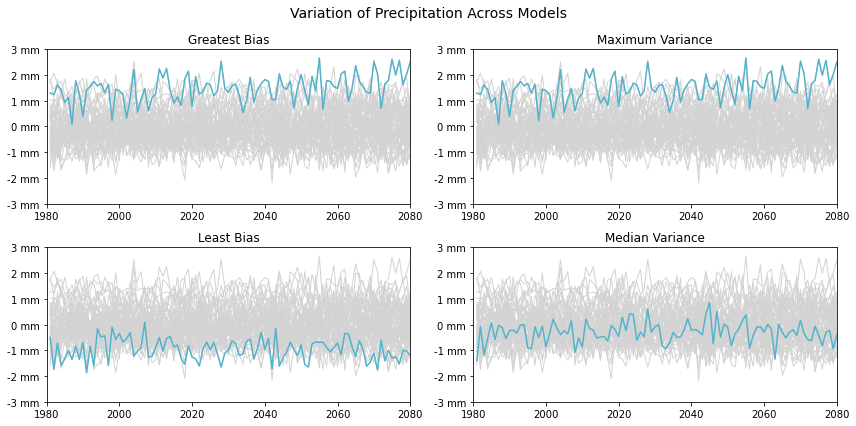

<Figure size 432x288 with 0 Axes>

In [34]:
dates = np.array([1981 + i for i in range(100)])
mean_pr = np.mean(pr_data,axis=0)

mse  = np.average((pr_data - mean_pr)**2,axis=1)
bias = np.average(pr_data - mean_pr,axis=1)
var  = mse - bias**2

varhist,edges = np.histogram(var)
varbincenters = 0.5 * (edges[1:] + edges[:-1])
msehist,edges = np.histogram(mse)
msebincenters = 0.5 * (edges[1:] + edges[:-1])
biashist,edges = np.histogram(bias**2)
biasbincenters = 0.5 * (edges[1:] + edges[:-1])

max_bias = np.argmax(bias)
min_bias = np.argmin(bias)
max_var  = np.argmax(var)
med_var  = np.where(np.median(var))
med_mse  = np.where(np.median(mse))


fig = plt.figure(figsize=(12, 6),tight_layout=True)

fig.suptitle('Variation of Precipitation Across Models',fontsize = 14)

widths = [1, 1]
heights = [1, 1]
grid = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths,height_ratios=heights)
bound = 3

ax_2 = fig.add_subplot(grid[0,0])
for k in range(48):
    ax_2.plot(dates,pr_data[k,:]-np.nanmean(pr_data,axis = 0),color='lightgray',linewidth=1)
ax_2.plot(dates,pr_data[max_bias,:]-np.nanmean(pr_data,axis = 0),color='#53B3CB',linewidth=1.5)
ax_2.set_title(f'Greatest Bias',fontsize=12)
ax_2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} mm"))
ax_2.set_xlim(1980,2080)
ax_2.set_ylim(-bound,bound)
ax_2.margins(x=0)

ax_3 = fig.add_subplot(grid[1,0])
for k in range(48):
    ax_3.plot(dates,pr_data[k,:]-np.nanmean(pr_data,axis = 0),color='lightgray',linewidth=1)
ax_3.plot(dates,pr_data[min_bias,:]-np.nanmean(pr_data,axis = 0),color='#53B3CB',linewidth=1.5)
ax_3.set_title(f'Least Bias',fontsize=12)
ax_3.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} mm"))
ax_3.set_xlim(1980,2080)
ax_3.set_ylim(-bound,bound)
ax_3.margins(x=0)

ax_4 = fig.add_subplot(grid[0,1])
for k in range(48):
    ax_4.plot(dates,pr_data[k,:]-np.nanmean(pr_data,axis = 0),color='lightgray',linewidth=1)
ax_4.plot(dates,pr_data[max_var,:]-np.nanmean(pr_data,axis = 0),color='#53B3CB',linewidth=1.5)
ax_4.set_title(f'Maximum Variance',fontsize=12)
ax_4.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} mm"))
ax_4.set_xlim(1980,2080)
ax_4.set_ylim(-bound,bound)
ax_4.margins(x=0)

ax_5 = fig.add_subplot(grid[1,1])
for k in range(48):
    ax_5.plot(dates,pr_data[k,:]-np.nanmean(pr_data,axis = 0),color='lightgray',linewidth=1)
ax_5.plot(dates,pr_data[med_var[0][0],:]-np.nanmean(pr_data,axis = 0),color='#53B3CB',linewidth=1.5)
ax_5.set_title(f'Median Variance',fontsize=12)
ax_5.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f} mm"))
ax_5.set_xlim(1980,2080)
ax_5.set_ylim(-bound,bound)
ax_5.margins(x=0)

plt.tight_layout()
plt.show()
plt.savefig('/home/theo/final_images/1.4.images/_rainfall')

25 13 36 24


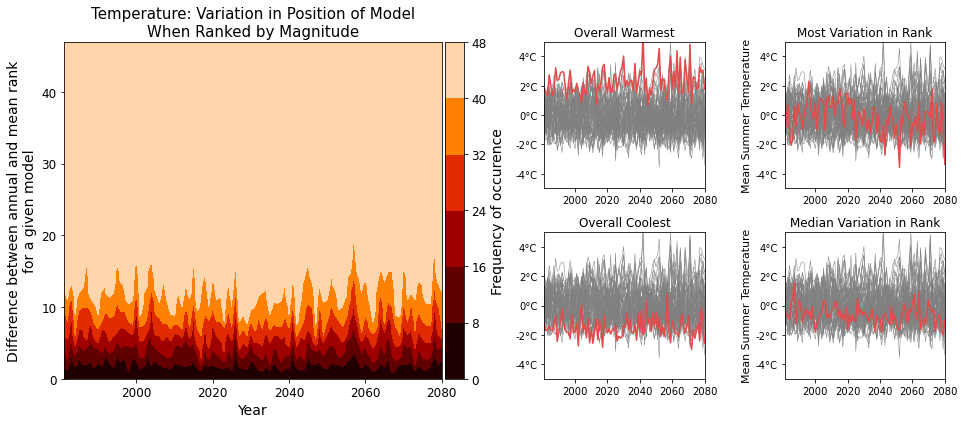

In [8]:
# Making Temperature Plot:

# Making dates:
dates = np.array([1981 + i for i in range(100)])


# Getting rank of each model:
tas = tas_data[:,1:101]        #first value nan as 1980 starts in December
sort = tas.argsort(axis=0)
ranks = np.empty_like(sort)
for i in range(100):
    ranks[:,i] = sort[:,i].argsort()
    #print(ranks[sort[:,i],i])
    #print(temperature[sort[:,i],i])



# Getting model mean ranks:
model_mean_rank = np.mean(ranks,axis=1)
model_rank_std = np.std(ranks,axis=1)

max_index = np.where(model_mean_rank == np.max(model_mean_rank))[0][0]
min_index = np.where(model_mean_rank == np.min(model_mean_rank))[0][0]
median_var_index = np.where(model_rank_std == model_rank_std.flat[np.abs(model_rank_std - np.median(model_rank_std)).argmin()])[0][0]
max_var_index = np.where(model_rank_std == np.max(model_rank_std))[0][0]

print(max_index,min_index,median_var_index,max_var_index)

# Building array(s) of number of ranks close to their mean
distance = np.arange(0,47+1,1)
heatmap  = np.zeros((distance.shape[0],100))
for j in range(len(distance)):
    num_within_distance = [np.sum((((ranks[:,i] - model_mean_rank)<j)&
                                   ((ranks[:,i] - model_mean_rank)>-j))) 
                           for i in range(100)]
    heatmap[j,:] = np.array(num_within_distance)



fig = plt.figure(figsize=(13.5, 6),tight_layout=True)

widths = [1, 1]
heights = [1, 1]
grid = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths,height_ratios=heights)

ax_1 = fig.add_subplot(grid[:,0])
cmap = plt.get_cmap('gist_heat')
fig_1 = ax_1.contourf(np.arange(1981,2081),np.arange(0,48),heatmap,cmap=cmap,levels=5+1)
yaxis = 'Difference between annual and mean rank\nfor a given model'
ax_1.set_title('Temperature: Variation in Position of Model\nWhen Ranked by Magnitude',fontsize=15)
ax_1.set_ylabel(yaxis,fontsize=14)
ax_1.set_xlabel('Year',fontsize=14)
plt.setp(ax_1.get_xticklabels(), fontsize=12) 
plt.setp(ax_1.get_yticklabels(), fontsize=12) 
divider = make_axes_locatable(ax_1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(fig_1, cax=cax, orientation='vertical')
cbar.set_label('Frequency of occurence',fontsize = 14)
plt.setp(cax.get_yticklabels(), fontsize=12)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax_2 = fig.add_subplot(grid[0,1])
    for k in range(48):
        ax_2.plot(dates,tas_data[k,:]-np.nanmean(tas_data,axis = 0),color='gray',linewidth=0.5)
    ax_2.plot(dates,tas_data[max_index,:]-np.nanmean(tas_data,axis = 0),color='#E54B4B',linewidth=1.5)
    ax_2.set_title(f'Overall Warmest',fontsize=12)
    ax_2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
    ax_2.set_ylim(-5,5)
    ax_2.margins(x=0)
    
    ax_3 = fig.add_subplot(grid[1,1])
    for k in range(47):
        ax_3.plot(dates,tas_data[k,:]-np.nanmean(tas_data,axis = 0),color='gray',linewidth=0.5)
    ax_3.plot(dates,tas_data[min_index,:]-np.nanmean(tas_data,axis = 0),color='#E54B4B',linewidth=1.5)
    ax_3.set_title(f'Overall Coolest',fontsize=12)
    ax_3.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
    ax_3.set_ylim(-5,5)
    ax_3.margins(x=0)
    
    ax_4 = fig.add_subplot(grid[0,2])
    for k in range(47):
        ax_4.plot(dates,tas_data[k,:]-np.nanmean(tas_data,axis = 0),color='gray',linewidth=0.5)
    ax_4.plot(dates,tas_data[max_var_index,:]-np.nanmean(tas_data,axis = 0),color='#E54B4B',linewidth=1.5)
    ax_4.set_title(f'Most Variation in Rank',fontsize=12)
    ax_4.set_ylabel(f'Mean Summer Temperature',fontsize=11)
    ax_4.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
    ax_4.set_ylim(-5,5)
    ax_4.margins(x=0)

    ax_5 = fig.add_subplot(grid[1,2])
    for k in range(47):
        ax_5.plot(dates,tas_data[k,:]-np.nanmean(tas_data,axis = 0),color='gray',linewidth=0.5)
    ax_5.plot(dates,tas_data[median_var_index,:]-np.nanmean(tas_data,axis = 0),color='#E54B4B',linewidth=1.5)
    ax_5.set_title(f'Median Variation in Rank',fontsize=12)
    ax_5.set_ylabel(f'Mean Summer Temperature',fontsize=11)
    ax_5.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
    ax_5.set_ylim(-5,5)
    ax_5.margins(x=0)
    
plt.savefig('/home/theo/final_images/1.4.images/Temperature_behaviour_by_model')

3 27 0 34


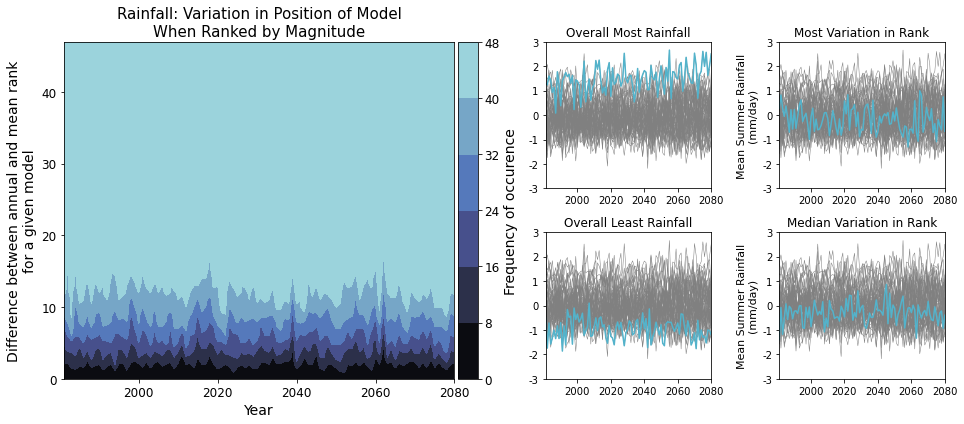

In [9]:
# Making Rainfall Plot:

# Making dates:
dates = np.array([1980 + i for i in range(101)])


# Getting rank of each model:
pr = pr_data[:,1:101]        #first value nan as 1980 starts in December
sort = pr.argsort(axis=0)
ranks = np.empty_like(sort)
for i in range(100):
    ranks[:,i] = sort[:,i].argsort()
    #print(ranks[sort[:,i],i])
    #print(temperature[sort[:,i],i])



# Getting model mean ranks:
model_mean_rank = np.mean(ranks,axis=1)
model_rank_std = np.std(ranks,axis=1)

max_index = np.where(model_mean_rank == np.max(model_mean_rank))[0][0]
min_index = np.where(model_mean_rank == np.min(model_mean_rank))[0][0]
median_var_index = np.where(model_rank_std == model_rank_std.flat[np.abs(model_rank_std - np.median(model_rank_std)).argmin()])[0][0]
max_var_index = np.where(model_rank_std == np.max(model_rank_std))[0][0]

print(max_index,min_index,median_var_index,max_var_index)

# Building array(s) of number of ranks close to their mean
distance = np.arange(0,47+1,1)
heatmap  = np.zeros((distance.shape[0],100))
for j in range(len(distance)):
    num_within_distance = [np.sum((((ranks[:,i] - model_mean_rank)<j)&
                                   ((ranks[:,i] - model_mean_rank)>-j))) 
                           for i in range(100)]
    heatmap[j,:] = np.array(num_within_distance)



fig = plt.figure(figsize=(13.5, 6),tight_layout=True)

widths = [2.5, 1, 1]
heights = [1, 1]
grid = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths,height_ratios=heights)

ax_1 = fig.add_subplot(grid[:,0])
cmap = plt.get_cmap('cmr.sapphire')
fig_1 = ax_1.contourf(np.arange(1981,2081),np.arange(0,48),heatmap,cmap=cmap,levels=5+1)
yaxis = 'Difference between annual and mean rank\nfor a given model'
ax_1.set_title('Rainfall: Variation in Position of Model\nWhen Ranked by Magnitude',fontsize=15)
ax_1.set_ylabel(yaxis,fontsize=14)
ax_1.set_xlabel('Year',fontsize=14)
plt.setp(ax_1.get_xticklabels(), fontsize=12) 
plt.setp(ax_1.get_yticklabels(), fontsize=12) 

divider = make_axes_locatable(ax_1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(fig_1, cax=cax, orientation='vertical')
cbar.set_label('Frequency of occurence',fontsize = 14)
plt.setp(cax.get_yticklabels(), fontsize=12)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax_2 = fig.add_subplot(grid[0,1])
    for k in range(47):
        ax_2.plot(dates,pr_data[k,:]-np.nanmean(pr_data,axis = 0),color='gray',linewidth=0.5)
    ax_2.plot(dates,pr_data[max_index,:]-np.nanmean(pr_data,axis = 0),color='#53B3CB',linewidth=1.5)
    ax_2.set_title(f'Overall Most Rainfall',fontsize=12)
    
    ax_2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
    ax_2.set_ylim(-3,3)
    ax_2.margins(x=0)
    
    ax_3 = fig.add_subplot(grid[1,1])
    for k in range(47):
        ax_3.plot(dates,pr_data[k,:]-np.nanmean(pr_data,axis = 0),color='gray',linewidth=0.5)
    ax_3.plot(dates,pr_data[min_index,:]-np.nanmean(pr_data,axis = 0),color='#53B3CB',linewidth=1.5)
    ax_3.set_title(f'Overall Least Rainfall',fontsize=12)
    ax_3.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
    ax_3.set_ylim(-3,3)
    ax_3.margins(x=0)
    
    ax_4 = fig.add_subplot(grid[0,2])
    for k in range(47):
        ax_4.plot(dates,pr_data[k,:]-np.nanmean(pr_data,axis = 0),color='gray',linewidth=0.5)
    ax_4.plot(dates,pr_data[max_var_index,:]-np.nanmean(pr_data,axis = 0),color='#53B3CB',linewidth=1.5)
    ax_4.set_title(f'Most Variation in Rank',fontsize=12)
    ax_4.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
    ax_4.set_ylabel(f'Mean Summer Rainfall\n(mm/day)',fontsize=11)
    ax_4.set_ylim(-3,3)
    ax_4.margins(x=0)

    ax_5 = fig.add_subplot(grid[1,2])
    for k in range(47):
        ax_5.plot(dates,pr_data[k,:]-np.nanmean(pr_data,axis = 0),color='gray',linewidth=0.5)
    ax_5.plot(dates,pr_data[median_var_index,:]-np.nanmean(pr_data,axis = 0),color='#53B3CB',linewidth=1.5)
    ax_5.set_title(f'Median Variation in Rank',fontsize=12)
    ax_5.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
    ax_5.set_ylabel(f'Mean Summer Rainfall\n(mm/day)',fontsize=11)
    ax_5.set_ylim(-3,3)
    ax_5.margins(x=0)
    
    
plt.savefig('/home/theo/final_images/1.4.images/Rainfall_behaviour_by_model')

19 42 8 17


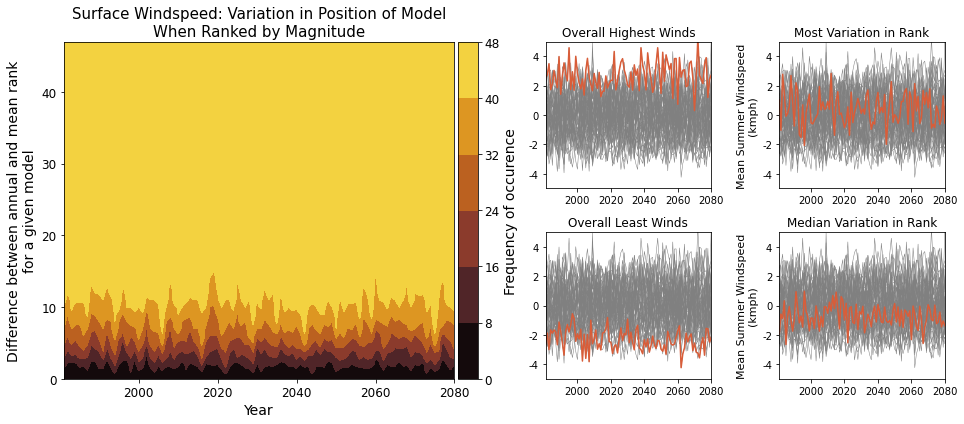

In [10]:
# Making Windspeed Plot:

# Making dates:
dates = np.array([1980 + i for i in range(101)])


# Getting rank of each model:
wind = wind_data[:,1:101]        #first value nan as 1980 starts in December
sort = wind.argsort(axis=0)
ranks = np.empty_like(sort)
for i in range(100):
    ranks[:,i] = sort[:,i].argsort()
    #print(ranks[sort[:,i],i])
    #print(temperature[sort[:,i],i])



# Getting model mean ranks:
model_mean_rank = np.mean(ranks,axis=1)
model_rank_std = np.std(ranks,axis=1)

max_index = np.where(model_mean_rank == np.max(model_mean_rank))[0][0]
min_index = np.where(model_mean_rank == np.min(model_mean_rank))[0][0]
median_var_index = np.where(model_rank_std == model_rank_std.flat[np.abs(model_rank_std - np.median(model_rank_std)).argmin()])[0][0]
max_var_index = np.where(model_rank_std == np.max(model_rank_std))[0][0]

print(max_index,min_index,median_var_index,max_var_index)

# Building array(s) of number of ranks close to their mean
distance = np.arange(0,47+1,1)
heatmap  = np.zeros((distance.shape[0],100))
for j in range(len(distance)):
    num_within_distance = [np.sum((((ranks[:,i] - model_mean_rank)<j)&
                                   ((ranks[:,i] - model_mean_rank)>-j))) 
                           for i in range(100)]
    heatmap[j,:] = np.array(num_within_distance)



fig = plt.figure(figsize=(13.5, 6),tight_layout=True)

widths = [2.5, 1, 1]
heights = [1, 1]
grid = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths,height_ratios=heights)

ax_1 = fig.add_subplot(grid[:,0])
cmap = plt.get_cmap('cmr.amber')
fig_1 = ax_1.contourf(np.arange(1981,2081),np.arange(0,48),heatmap,cmap=cmap,levels=5+1)
yaxis = 'Difference between annual and mean rank\nfor a given model'
ax_1.set_title('Surface Windspeed: Variation in Position of Model\nWhen Ranked by Magnitude',fontsize=15)
ax_1.set_ylabel(yaxis,fontsize=14)
ax_1.set_xlabel('Year',fontsize=14)
plt.setp(ax_1.get_xticklabels(), fontsize=12) 
plt.setp(ax_1.get_yticklabels(), fontsize=12) 

divider = make_axes_locatable(ax_1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(fig_1, cax=cax, orientation='vertical')
cbar.set_label('Frequency of occurence',fontsize = 14)
plt.setp(cax.get_yticklabels(), fontsize=12)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax_2 = fig.add_subplot(grid[0,1])
    for k in range(47):
        ax_2.plot(dates,wind_data[k,:]-np.nanmean(wind_data,axis = 0),color='gray',linewidth=0.5)
    ax_2.plot(dates,wind_data[max_index,:]-np.nanmean(wind_data,axis = 0),color='#D95D39',linewidth=1.5)
    ax_2.set_title(f'Overall Highest Winds',fontsize=12)
    
    ax_2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
    ax_2.set_ylim(-5,5)
    ax_2.margins(x=0)
    
    ax_3 = fig.add_subplot(grid[1,1])
    for k in range(47):
        ax_3.plot(dates,wind_data[k,:]-np.nanmean(wind_data,axis = 0),color='gray',linewidth=0.5)
    ax_3.plot(dates,wind_data[min_index,:]-np.nanmean(wind_data,axis = 0),color='#D95D39',linewidth=1.5)
    ax_3.set_title(f'Overall Least Winds',fontsize=12)
    ax_3.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
    ax_3.set_ylim(-5,5)
    ax_3.margins(x=0)
    
    ax_4 = fig.add_subplot(grid[0,2])
    for k in range(47):
        ax_4.plot(dates,wind_data[k,:]-np.nanmean(wind_data,axis = 0),color='gray',linewidth=0.5)
    ax_4.plot(dates,wind_data[max_var_index,:]-np.nanmean(wind_data,axis = 0),color='#D95D39',linewidth=1.5)
    ax_4.set_title(f'Most Variation in Rank',fontsize=12)
    ax_4.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
    ax_4.set_ylabel(f'Mean Summer Windspeed\n(kmph)',fontsize=11)
    ax_4.set_ylim(-5,5)
    ax_4.margins(x=0)

    ax_5 = fig.add_subplot(grid[1,2])
    for k in range(47):
        ax_5.plot(dates,wind_data[k,:]-np.nanmean(wind_data,axis = 0),color='gray',linewidth=0.5)
    ax_5.plot(dates,wind_data[median_var_index,:]-np.nanmean(wind_data,axis = 0),color='#D95D39',linewidth=1.5)
    ax_5.set_title(f'Median Variation in Rank',fontsize=12)
    ax_5.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
    ax_5.set_ylabel(f'Mean Summer Windspeed\n(kmph)',fontsize=11)
    ax_5.set_ylim(-5,5)
    ax_5.margins(x=0)
    
    
plt.savefig('/home/theo/final_images/1.4.images/Windspeed_behaviour_by_model')

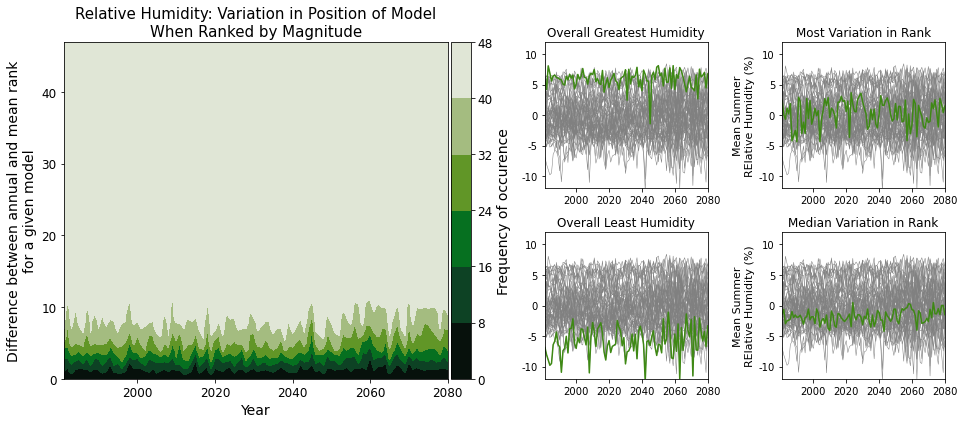

In [11]:
# Making RH Plot:

# Making dates:
dates = np.array([1980 + i for i in range(101)])


# Getting rank of each model:
hurs = hurs_data[:,1:101]        #first value nan as 1980 starts in December
sort = hurs.argsort(axis=0)
ranks = np.empty_like(sort)
for i in range(100):
    ranks[:,i] = sort[:,i].argsort()
    #print(ranks[sort[:,i],i])
    #print(temperature[sort[:,i],i])



# Getting model mean ranks:
model_mean_rank = np.mean(ranks,axis=1)
model_rank_std = np.std(ranks,axis=1)

max_index = np.where(model_mean_rank == np.max(model_mean_rank))[0][0]
min_index = np.where(model_mean_rank == np.min(model_mean_rank))[0][0]
median_var_index = np.where(model_rank_std == model_rank_std.flat[np.abs(model_rank_std - np.median(model_rank_std)).argmin()])[0][0]
max_var_index = np.where(model_rank_std == np.max(model_rank_std))[0][0]

# Building array(s) of number of ranks close to their mean
distance = np.arange(0,47+1,1)
heatmap  = np.zeros((distance.shape[0],100))
for j in range(len(distance)):
    num_within_distance = [np.sum((((ranks[:,i] - model_mean_rank)<j)&
                                   ((ranks[:,i] - model_mean_rank)>-j))) 
                           for i in range(100)]
    heatmap[j,:] = np.array(num_within_distance)



fig = plt.figure(figsize=(13.5, 6),tight_layout=True)

widths = [2.5, 1, 1]
heights = [1, 1]
grid = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths,height_ratios=heights)

ax_1 = fig.add_subplot(grid[:,0])
cmap = plt.get_cmap('cmr.jungle')
fig_1 = ax_1.contourf(np.arange(1981,2081),np.arange(0,48),heatmap,cmap=cmap,levels=5+1)
yaxis = 'Difference between annual and mean rank\nfor a given model'
ax_1.set_title('Relative Humidity: Variation in Position of Model\nWhen Ranked by Magnitude',fontsize=15)
ax_1.set_ylabel(yaxis,fontsize=14)
ax_1.set_xlabel('Year',fontsize=14)
plt.setp(ax_1.get_xticklabels(), fontsize=12) 
plt.setp(ax_1.get_yticklabels(), fontsize=12) 

divider = make_axes_locatable(ax_1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(fig_1, cax=cax, orientation='vertical')
cbar.set_label('Frequency of occurence',fontsize = 14)
plt.setp(cax.get_yticklabels(), fontsize=12)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax_2 = fig.add_subplot(grid[0,1])
    for k in range(47):
        ax_2.plot(dates,hurs_data[k,:]-np.nanmean(hurs_data,axis = 0),color='gray',linewidth=0.5)
    ax_2.plot(dates,hurs_data[max_index,:]-np.nanmean(hurs_data,axis = 0),color='#3E8914',linewidth=1.5)
    ax_2.set_title(f'Overall Greatest Humidity',fontsize=12)
    
    ax_2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
    ax_2.set_ylim(-12,12)
    ax_2.margins(x=0)
    
    ax_3 = fig.add_subplot(grid[1,1])
    for k in range(47):
        ax_3.plot(dates,hurs_data[k,:]-np.nanmean(hurs_data,axis = 0),color='gray',linewidth=0.5)
    ax_3.plot(dates,hurs_data[min_index,:]-np.nanmean(hurs_data,axis = 0),color='#3E8914',linewidth=1.5)
    ax_3.set_title(f'Overall Least Humidity',fontsize=12)
    ax_3.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
    ax_3.set_ylim(-12,12)
    ax_3.margins(x=0)
    
    ax_4 = fig.add_subplot(grid[0,2])
    for k in range(47):
        ax_4.plot(dates,hurs_data[k,:]-np.nanmean(hurs_data,axis = 0),color='gray',linewidth=0.5)
    ax_4.plot(dates,hurs_data[max_var_index,:]-np.nanmean(hurs_data,axis = 0),color='#3E8914',linewidth=1.5)
    ax_4.set_title(f'Most Variation in Rank',fontsize=12)
    ax_4.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
    ax_4.set_ylabel(f'Mean Summer\nRElative Humidity (%)',fontsize=11)
    ax_4.set_ylim(-12,12)
    ax_4.margins(x=0)

    ax_5 = fig.add_subplot(grid[1,2])
    for k in range(47):
        ax_5.plot(dates,hurs_data[k,:]-np.nanmean(hurs_data,axis = 0),color='gray',linewidth=0.5)
    ax_5.plot(dates,hurs_data[median_var_index,:]-np.nanmean(hurs_data,axis = 0),color='#3E8914',linewidth=1.5)
    ax_5.set_title(f'Median Variation in Rank',fontsize=12)
    ax_5.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
    ax_5.set_ylabel(f'Mean Summer\nRElative Humidity (%)',fontsize=11)
    ax_5.set_ylim(-12,12)
    ax_5.margins(x=0)
    
    
plt.savefig('/home/theo/final_images/1.4.images/RH_behaviour_by_model')

In [ ]:
def get_heatmap(in_data):
    # Getting rank of each model:
    data = in_data[:,1:101]        #first value nan as 1980 starts in December
    sort = data.argsort(axis=0)
    ranks = np.empty_like(sort)
    for i in range(100):
        ranks[:,i] = sort[:,i].argsort()
        #print(ranks[sort[:,i],i])
        #print(temperature[sort[:,i],i])



    # Getting model mean ranks:
    model_mean_rank = np.mean(ranks,axis=1)
    model_rank_std = np.std(ranks,axis=1)

    max_index = np.where(model_mean_rank == np.max(model_mean_rank))[0][0]
    min_index = np.where(model_mean_rank == np.min(model_mean_rank))[0][0]
    median_var_index = np.where(model_rank_std == model_rank_std.flat[np.abs(model_rank_std - np.median(model_rank_std)).argmin()])[0][0]
    max_var_index = np.where(model_rank_std == np.max(model_rank_std))[0][0]

    # Building array(s) of number of ranks close to their mean
    distance = np.arange(0,47+1,1)
    heatmap  = np.zeros((distance.shape[0],100))
    for j in range(len(distance)):
        num_within_distance = [np.sum((((ranks[:,i] - model_mean_rank)<j)&
                                       ((ranks[:,i] - model_mean_rank)>-j))) 
                               for i in range(100)]
        heatmap[j,:] = np.array(num_within_distance)
    
    
    return heatmap,max_index,min_index,median_var_index,max_var_index

In [ ]:

# Making dates:
dates = np.array([1980 + i for i in range(101)])


fig = plt.figure(figsize=(12, 10),tight_layout=True)


grid = fig.add_gridspec(ncols=12, nrows=10,wspace=12,hspace=12)

heatmap,max_index,min_index,median_var_index,max_var_index = get_heatmap(tas_data)

ax_1 = fig.add_subplot(grid[0:6,0:6])
cmap = plt.get_cmap('gist_heat')
fig_1 = ax_1.contourf(np.arange(1981,2081),np.arange(0,48),heatmap,cmap=cmap,levels=5+1)
yaxis = 'Difference between annual and\nmean rank for a given model'
ax_1.set_title('Temperature: Variation in Position of\nModel When Ranked by Magnitude',fontsize=14)
ax_1.set_ylabel(yaxis,fontsize=13)
ax_1.set_xlabel('Year',fontsize=13)
plt.setp(ax_1.get_xticklabels(), fontsize=11) 
plt.setp(ax_1.get_yticklabels(), fontsize=11) 

divider = make_axes_locatable(ax_1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(fig_1, cax=cax, orientation='vertical')
plt.setp(cax.get_yticklabels(), fontsize=11)





with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    ax_2 = fig.add_subplot(grid[0:3,6:9])
    for k in range(47):
        ax_2.plot(dates,tas_data[k,:]-np.nanmean(tas_data,axis = 0),color='gray',linewidth=0.5)
    ax_2.plot(dates,tas_data[max_index,:]-np.nanmean(tas_data,axis = 0),color='#E54B4B',linewidth=1.5)
    ax_2.set_title(f'Greatest Overestimation',fontsize=12)
    ax_2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
    ax_2.set_ylim(-5,5)
    ax_2.margins(x=0)





    ax_3 = fig.add_subplot(grid[3:6,6:9])
    for k in range(47):
        ax_3.plot(dates,tas_data[k,:]-np.nanmean(tas_data,axis = 0),color='gray',linewidth=0.5)
    ax_3.plot(dates,tas_data[min_index,:]-np.nanmean(tas_data,axis = 0),color='#E54B4B',linewidth=1.5)
    ax_3.set_title(f'Greatest Underestimation',fontsize=12)
    ax_3.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
    ax_3.set_ylim(-5,5)
    ax_3.margins(x=0)
    
    
    
    
    ax_4 = fig.add_subplot(grid[0:3,9:12])
    for k in range(47):
        ax_4.plot(dates,tas_data[k,:]-np.nanmean(tas_data,axis = 0),color='gray',linewidth=0.5)
    ax_4.plot(dates,tas_data[max_var_index,:]-np.nanmean(tas_data,axis = 0),color='#E54B4B',linewidth=1.5)
    ax_4.set_title(f'Most Variation in Rank',fontsize=12)
    ax_4.set_ylabel(f'Mean Temperature',fontsize=11)
    ax_4.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
    ax_4.set_ylim(-5,5)
    ax_4.margins(x=0)
    
    
    
    
    
    
    
    ax_5 = fig.add_subplot(grid[3:6,9:12])
    for k in range(47):
        ax_5.plot(dates,tas_data[k,:]-np.nanmean(tas_data,axis = 0),color='gray',linewidth=0.5)
    ax_5.plot(dates,tas_data[median_var_index,:]-np.nanmean(tas_data,axis = 0),color='#E54B4B',linewidth=1.5)
    ax_5.set_title(f'Median Variation in Rank',fontsize=12)
    ax_5.set_ylabel(f'Mean Temperature',fontsize=11)
    ax_5.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
    ax_5.set_ylim(-5,5)
    ax_5.margins(x=0)
    
    
    

heatmap,max_index,min_index,median_var_index,max_var_index = get_heatmap(pr_data)

ax_6 = fig.add_subplot(grid[6:10,0:4])
cmap = plt.get_cmap('cmr.sapphire')
fig_6 = ax_6.contourf(np.arange(1981,2081),np.arange(0,48),heatmap,cmap=cmap,levels=5+1)
yaxis = 'Difference between annual and\nmean rank for a given model'
ax_6.set_title('Rainfall',fontsize=14)
plt.setp(ax_6.get_xticklabels(), fontsize=11) 
plt.setp(ax_6.get_yticklabels(), fontsize=11) 

divider = make_axes_locatable(ax_6)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(fig_6, cax=cax, orientation='vertical')
plt.setp(cax.get_yticklabels(), fontsize=11)




heatmap,max_index,min_index,median_var_index,max_var_index = get_heatmap(wind_data)

ax_7 = fig.add_subplot(grid[6:10,4:8])
cmap = plt.get_cmap('cmr.amber')
fig_7 = ax_7.contourf(np.arange(1981,2081),np.arange(0,48),heatmap,cmap=cmap,levels=5+1)
yaxis = 'Difference between annual and\nmean rank for a given model'
ax_7.set_title('Surface Windspeed',fontsize=14)
plt.setp(ax_7.get_xticklabels(), fontsize=11) 
plt.setp(ax_7.get_yticklabels(), fontsize=11) 

divider = make_axes_locatable(ax_7)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(fig_7, cax=cax, orientation='vertical')
plt.setp(cax.get_yticklabels(), fontsize=11)



heatmap,max_index,min_index,median_var_index,max_var_index = get_heatmap(hurs_data)

ax_8 = fig.add_subplot(grid[6:10,8:12])
cmap = plt.get_cmap('cmr.jungle')
fig_8 = ax_8.contourf(np.arange(1981,2081),np.arange(0,48),heatmap,cmap=cmap,levels=5+1)
yaxis = 'Difference between annual and mean rank\nfor a given model'
ax_8.set_title('Relative Humidity',fontsize=14)
plt.setp(ax_8.get_xticklabels(), fontsize=11) 
plt.setp(ax_8.get_yticklabels(), fontsize=11) 

divider = make_axes_locatable(ax_8)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(fig_8, cax=cax, orientation='vertical')
plt.setp(cax.get_yticklabels(), fontsize=11)

plt.savefig('/home/theo/final_images/1.4.images/combo_with_temp_focus')